In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import sys
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import seaborn
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import MultiLabelBinarizer
porter = PorterStemmer()
lancaster=LancasterStemmer()
seaborn.set()
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

def score_corr(model, X_test, y_test, df):
    accept = 0
    total = len(X_test)
    
    datafr = pd.DataFrame(y_test)
    index_list = datafr.reset_index()['index'].tolist()
    
    predict = model.predict(X_test)
    predict_list = predict.tolist()
    
    for i in range(len(X_test)):
        accept_list = []
        index = index_list[i]
        accept_list.append(df['genres_number'][index])
        if index > 1:
            index_m1 = index - 1
            index_m2 = index - 2
            index_p1 = index + 1
            index_p2 = index + 2
            if df['plot'][index] == df['plot'][index_m1]:
                accept_list.append(df['genres_number'][index_m1])
            if df['plot'][index] == df['plot'][index_m2]:
                accept_list.append(df['genres_number'][index_m2])
            if index_p1 <= max(index_list):
                if df['plot'][index] == df['plot'][index_p1]:
                    accept_list.append(df['genres_number'][index_p1])
            if index_p2 <= max(index_list):      
                if df['plot'][index] == df['plot'][index_p2]:
                    accept_list.append(df['genres_number'][index_p2])
        elif index == 1:
            index_m1 = index - 1
            index_p1 = index + 1
            index_p2 = index + 2
            if df['plot'][index] == df['plot'][index_m1]:
                accept_list.append(df['genres_number'][index_m1])
            if df['plot'][index] == df['plot'][index_p1]:
                accept_list.append(df['genres_number'][index_p1])
            if df['plot'][index] == df['plot'][index_p2]:
                accept_list.append(df['genres_number'][index_p2])
        else:
            index_p1 = index + 1
            index_p2 = index + 2
            if df['plot'][index] == df['plot'][index_p1]:
                accept_list.append(df['genres_number'][index_p1])
            if df['plot'][index] == df['plot'][index_p2]:
                accept_list.append(df['genres_number'][index_p2])
                
        if predict_list[i] in accept_list:
            accept = accept + 1
        
    score = accept / total
    print ('The corrected score for testing data is: ', score)
    return score

def get_partition(number_movies):
    total = 0
    for x in number_movies:
        total += number_movies[x]
    for x in number_movies:
        number_movies[x] = number_movies[x]/total
    return number_movies

def get_genres(omdb):
    genres = []
    for i in omdb['omdb_genres']:
        for j in i:
            if j not in genres:
                genres.append(j)
    dic_genres = {}
    for i in genres:
        dic_genres.setdefault(i, [])

    for index,j in enumerate(omdb['omdb_genres']):
        for i in j:
            if i in dic_genres:
                dic_genres[i].append(omdb['omdb_plot'][index])
    return dic_genres

def each_number_genres(genres_comment):
    number_movies = {}
    for i in genres_comment:
        length = len(genres_comment[i])
        number_movies.setdefault(i,length)
    return number_movies

def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

def stemSentence_porter(sentence):
    token_words=word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def token_plot_porter(omdb):
    omdb_temp = omdb.copy()
    for index,plot in enumerate(omdb_temp['omdb_plot']):
        omdb_temp['omdb_plot'][index] = stemSentence_porter(plot)
    return omdb_temp

def stemSentence_lancaster(sentence):
    token_words=word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lancaster.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def token_plot_lancaster(omdb):
    omdb_temp = omdb.copy()
    for index,plot in enumerate(omdb_temp['omdb_plot']):
        omdb_temp['omdb_plot'][index] = stemSentence_lancaster(plot)
    return omdb_temp

In [2]:
## read data from omdb-data.json.gz
omdb = pd.read_json('omdb-data.json.gz', orient='record', lines=True)

In [3]:
## get all distinct genres
genres = []
for i in omdb['omdb_genres']:
    for j in i:
        if j not in genres:
            genres.append(j)
genres

['Drama',
 'History',
 'War',
 'Action',
 'Adventure',
 'Thriller',
 'Comedy',
 'Horror',
 'Crime',
 'Sci-Fi',
 'Fantasy',
 'Mystery',
 'Biography',
 'Music',
 'Family',
 'Musical',
 'Romance',
 'Animation',
 'Documentary',
 'Short',
 'Sport',
 'N/A',
 'Western',
 'News',
 'Talk-Show',
 'Film-Noir',
 'Adult']

In [4]:
genres_comment = get_genres(omdb)

In [5]:
## get the number of movies for each genres
number_movies = each_number_genres(genres_comment)
number_movies

{'Drama': 4676,
 'History': 387,
 'War': 304,
 'Action': 1964,
 'Adventure': 1638,
 'Thriller': 1190,
 'Comedy': 3134,
 'Horror': 1152,
 'Crime': 1530,
 'Sci-Fi': 801,
 'Fantasy': 774,
 'Mystery': 649,
 'Biography': 688,
 'Music': 318,
 'Family': 676,
 'Musical': 167,
 'Romance': 1527,
 'Animation': 546,
 'Documentary': 757,
 'Short': 68,
 'Sport': 142,
 'N/A': 22,
 'Western': 132,
 'News': 18,
 'Talk-Show': 1,
 'Film-Noir': 83,
 'Adult': 4}

In [6]:
## select all genres which appear more than 800 times
filtered_movies = {}
for i in number_movies:
    if number_movies[i] >= 800:
        filtered_movies.update({i: number_movies[i]})
filtered_movies

{'Drama': 4676,
 'Action': 1964,
 'Adventure': 1638,
 'Thriller': 1190,
 'Comedy': 3134,
 'Horror': 1152,
 'Crime': 1530,
 'Sci-Fi': 801,
 'Romance': 1527}

In [7]:
data = get_partition(filtered_movies)

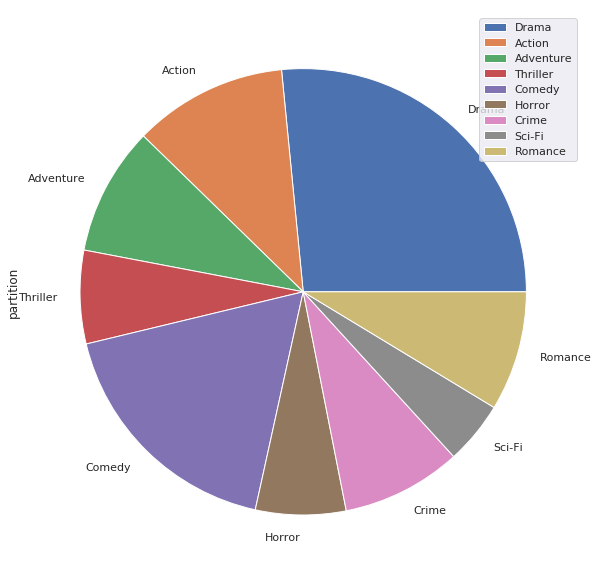

In [8]:
## show the partition as pie chart for rest genres
df = pd.DataFrame.from_dict(data,orient='index',columns = ['partition'])
df.plot.pie(y='partition', figsize=(10, 15))

In [9]:
## show the rest genres
filtered_genres = [x for x in filtered_movies]
print(filtered_genres)

['Drama', 'Action', 'Adventure', 'Thriller', 'Comedy', 'Horror', 'Crime', 'Sci-Fi', 'Romance']


In [10]:
## remove all filtered genres in omdb
for index, genres in enumerate(omdb['omdb_genres']):
    temp = []
    for i in genres:
        if i in filtered_genres:
            temp.append(i)
    if temp != []:
        omdb['omdb_genres'][index] = temp
    else:
        omdb['omdb_genres'][index] = []


In [11]:
## delete all tuples that all their genres are filtered genres
omdb = omdb[omdb.astype(str)['omdb_genres'] != '[]'].reset_index(drop=True)

In [12]:
## 1.remove all '\' and etc. 2.also change all upper case to lower cases
omdb['omdb_plot'] = omdb['omdb_plot'].apply(lambda x: clean_text(x))

In [13]:
## build new dataframe by converting the plot to the stemed plot by porter and lancaster
omdb_porter = token_plot_porter(omdb)
omdb_lancaster = token_plot_lancaster(omdb)

In [14]:
## get frequency of each word
merged_list = ''
for i in omdb_lancaster['omdb_plot']:
    merged_list = merged_list + i + ' '
tokenized_word = word_tokenize(merged_list)
fdist = FreqDist(tokenized_word)

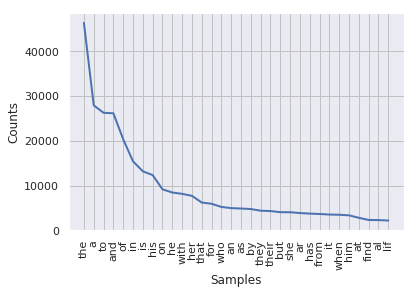

In [15]:
fdist.plot(32,cumulative=False)
plt.show()

In [16]:
## show stop words
stop_words=set(stopwords.words("english"))
print(stop_words)

{'herself', 'were', 'theirs', 'hadn', 'their', 'both', "shan't", 'i', 'wasn', 'don', 'ourselves', "she's", "hasn't", 'mustn', 'these', 'is', 'who', 'if', 'into', 'what', 'further', "wasn't", 'under', 'own', 'this', 'while', 'y', 'couldn', 'our', 'a', 'can', 'so', 'very', 'isn', "wouldn't", 'your', 'of', 'here', 'above', 'out', 'such', 'why', 'until', "it's", 'weren', 'too', 'needn', "doesn't", 'myself', 'whom', 'are', 'off', 'below', 've', 'haven', 'it', 'we', 'an', 'at', 'about', 'once', 'me', 'yours', "you'd", "couldn't", 'nor', "should've", 'ain', 'having', 'before', 'has', 'being', 'again', "mightn't", 'am', 'as', 'any', 'wouldn', "you're", 'himself', 'mightn', 'did', 'they', 'in', 'its', 'will', 'him', 'not', "that'll", 'by', "won't", "shouldn't", 'had', "aren't", 'just', 'that', 'yourself', 'more', 'the', 'her', 'some', 't', 'ma', 'won', 'he', "don't", 'no', 'and', 'all', 'doesn', 'my', 'you', 'shan', 'yourselves', 'those', 'through', 'each', 're', 'itself', "didn't", 's', "haven

In [17]:
## remove all stop words for porter and lancaster database
for index, plot in enumerate(omdb_porter['omdb_plot']):
    temp = plot.split()
    temp_list = ''
    for i in temp:
        if i not in stop_words:
            temp_list = temp_list + ' ' + i
    omdb_porter['omdb_plot'][index] = temp_list

In [18]:
for index, plot in enumerate(omdb_lancaster['omdb_plot']):
    temp = plot.split()
    temp_list = ''
    for i in temp:
        if i not in stop_words:
            temp_list = temp_list + ' ' + i
    omdb_lancaster['omdb_plot'][index] = temp_list

In [19]:
## get data need to be filtered
filtered_sent_lancaster=[]
for w in tokenized_word:
    if w not in stop_words:
        filtered_sent_lancaster.append(w)


In [20]:
merged_list = ''
for i in omdb_porter['omdb_plot']:
    merged_list = merged_list + i + ' '
tokenized_word = word_tokenize(merged_list)
fdist = FreqDist(tokenized_word)

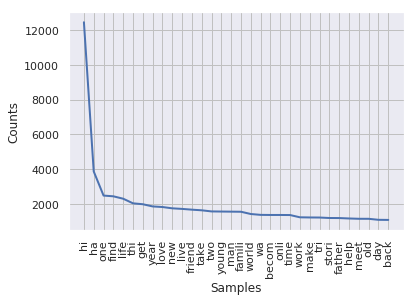

In [21]:
## show the plot of stemed data with high frequency
fdist.plot(32,cumulative=False)
plt.show()

In [22]:
filtered_sent_porter=[]
for w in tokenized_word:
    if w not in stop_words:
        filtered_sent_porter.append(w)

In [23]:
## assign different numbers to each genres we have
dic_saving_genres = {}
for index, genres in enumerate(filtered_genres):
    dic_saving_genres.update({genres: index})
dic_saving_genres

{'Drama': 0,
 'Action': 1,
 'Adventure': 2,
 'Thriller': 3,
 'Comedy': 4,
 'Horror': 5,
 'Crime': 6,
 'Sci-Fi': 7,
 'Romance': 8}

In [24]:
genres_comment = get_genres(omdb)

In [25]:
## create predict_df table
predict_df = pd.DataFrame(columns=['genres_number', 'plot'])

In [26]:
## seperate each plot based how many genres its corresponding to 
for index,genres in enumerate(omdb['omdb_genres']):
    for i in genres:
        row = [dic_saving_genres[i],omdb['omdb_plot'][index]]
        predict_df.loc[len(predict_df)] = row
predict_df

,genres_number,plot
0,0,in this sprawling star laden film we see the s...
1,1,a cryptic message from the past sends james bo...
2,2,a cryptic message from the past sends james bo...
3,3,a cryptic message from the past sends james bo...
4,4,the makers of this parody of night of the livi...
5,5,the makers of this parody of night of the livi...
6,2,jack crabb is years old as the film begins a c...
7,4,jack crabb is years old as the film begins a c...
8,0,jack crabb is years old as the film begins a c...
9,6,when perry and his girlfriend gail cross paths...


In [27]:
## score of tfidfor each genre of plot without stem
selector = SelectPercentile(f_classif, percentile=20)
vectorizer = TfidfVectorizer(max_df = 0.4,stop_words='english')
y = predict_df['genres_number'].astype('int')
X = predict_df['plot']
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train = vectorizer.fit_transform(X_train)
    
selector.fit(X_train,y_train)
X_train = selector.transform(X_train).toarray()
    
model = MultinomialNB(alpha=1 ,fit_prior = False)
model.fit(X_train,y_train)
X_test = vectorizer.transform(X_test)
X_test = selector.transform(X_test).toarray()
print(model.score(X_test,y_test))

0.29616170792641383


In [28]:
## score of tfid for each genre of plot scored by ourselves without stem
score_corr(model, X_test, y_test, predict_df)

The corrected score for testing data is:  0.800136270724506


0.800136270724506

In [29]:
predict_df_porter = pd.DataFrame(columns=['genres_number', 'plot'])
for index,genres in enumerate(omdb_porter['omdb_genres']):
    for i in genres:
        row = [dic_saving_genres[i],omdb_porter['omdb_plot'][index]]
        predict_df_porter.loc[len(predict_df_porter)] = row
predict_df_porter

,genres_number,plot
0,0,thi sprawl star laden film see struggl variou...
1,1,cryptic messag past send jame bond rogu missi...
2,2,cryptic messag past send jame bond rogu missi...
3,3,cryptic messag past send jame bond rogu missi...
4,4,maker thi parodi night live dead took georg r...
5,5,maker thi parodi night live dead took georg r...
6,2,jack crabb year old film begin collector oral...
7,4,jack crabb year old film begin collector oral...
8,0,jack crabb year old film begin collector oral...
9,6,perri hi girlfriend gail cross path charismat...


In [30]:
## tfid for each genre of plot with stem
selector = SelectPercentile(f_classif, percentile=20)
vectorizer = TfidfVectorizer(max_df = 0.4,stop_words='english')
y = predict_df_porter['genres_number'].astype('int')
X = predict_df_porter['plot']
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train = vectorizer.fit_transform(X_train)
    
selector.fit(X_train,y_train)
X_train = selector.transform(X_train).toarray()
    
model = MultinomialNB(alpha=1 ,fit_prior = False)
model.fit(X_train,y_train)
X_test = vectorizer.transform(X_test)
X_test = selector.transform(X_test).toarray()
print(model.score(X_test,y_test))

0.30297524415171473


In [31]:
## tfid for each genre of plot scored by ourselves with stem
score_corr(model, X_test, y_test, predict_df_porter)

The corrected score for testing data is:  0.8046786282080399


0.8046786282080399

In [32]:
## MultiLabelBinarizer(list of genres) tfid with stem
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(omdb_porter['omdb_genres'])
y = multilabel_binarizer.transform(omdb_porter['omdb_genres'])
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000, stop_words = 'english')

X_train, X_test, y_train, y_test = train_test_split(omdb_porter['omdb_plot'], y, test_size=0.2, random_state=9)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

f1_score(y_test, y_pred, average="micro")



/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5185462720119894

In [33]:
## MultiLabelBinarizer(list of genres) tfid with stem and probability estimate
y_pred_prob = clf.predict_proba(X_test_tfidf)

t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

f1_score(y_test, y_pred_new, average="micro")

0.6404809619238477

In [34]:
## MultiLabelBinarizer(list of genres) count with stem
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(omdb_porter['omdb_genres'])
y = multilabel_binarizer.transform(omdb_porter['omdb_genres'])
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
#tokenizer to remove unwanted elements from out data like symbols and numbers
# token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1))

X_train, X_test, y_train, y_test = train_test_split(omdb_porter['omdb_plot'], y, test_size=0.2, random_state=9)

X_train_tfidf = cv.fit_transform(X_train)
X_test_tfidf = cv.transform(X_test)

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

f1_score(y_test, y_pred, average="micro")


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5953983408984191

In [35]:
## MultiLabelBinarizer(list of genres) count with stem and probability estimate
y_pred_prob = clf.predict_proba(X_test_tfidf)

t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

f1_score(y_test, y_pred_new, average="micro")

0.6205496141870854

In [36]:
## MultiLabelBinarizer(list of genres) tfid without stem
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(omdb['omdb_genres'])
y = multilabel_binarizer.transform(omdb['omdb_genres'])
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000, stop_words = 'english')

X_train, X_test, y_train, y_test = train_test_split(omdb['omdb_plot'], y, test_size=0.2, random_state=9)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

f1_score(y_test, y_pred, average="micro")



/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5004793863854267

In [37]:
## MultiLabelBinarizer(list of genres) tfid without stem and probability estimate
y_pred_prob = clf.predict_proba(X_test_tfidf)

t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

f1_score(y_test, y_pred_new, average="micro")

0.6255210434314912

In [38]:
# https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/